In [2]:
import numpy as np
import math
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import *
import matplotlib.pyplot as plt
from matplotlib.colors import *
from scipy.interpolate import *
sys.path.insert(0, '/Users/skhan/athena/vis/python')
import athena_read
from h5py import File

In [ ]:
# Given parameters
r_min = 0.3
r_max = 5.0
N_r = 384
# Calculate x1 ratio for a log-uniform grid
x1 = (r_max / r_min) ** (1.0 / N_r)

# Print x1 to 15 decimal places
print(f"x1 = {x1:.15f}")

In [3]:
data = athena_read.athdf('/Users/skhan/fixed_2D_no_amr/disk.out1.00790.athdf')
dens = data.get('rho')[0]
dens_dust = data.get('dust_1_rho')[0]
r_c = data.get('x1v')
phi_c = data.get('x2v')
orbits = data.get('Time')/(2. * np.pi)
phi_f= data.get('x2f')
r_f = data.get('x1f')
v_r = data.get('vel1')[0]
v_phi = data.get('vel2')[0]
v_r_dust = data.get('dust_1_vel1')[0]
v_phi_dust = data.get('dust_1_vel2')[0]
vortensity = data.get('user_out_var0')[0]
stokes = 1.25*np.pi / (152*dens)
press = data.get('press')[0]

d_phi = phi_f[:, None]
d_phi = d_phi[1:] - d_phi[:-1]
d_r = r_f[1:] - r_f[:-1]

In [539]:
data = athena_read.athdf('/Users/skhan/3D_simulation/disk.out1.00600.athdf')
dens = data.get('rho')
dens_dust = data.get('dust_1_rho')
r_c = data.get('x1v')
theta_c = data.get('x2v')
phi_c = data.get('x3v')
orbits = data.get('Time')/(2. * np.pi)
theta_f= data.get('x2f')
phi_f = data.get('x3f')
r_f = data.get('x1f')
v_r = data.get('vel1')
v_theta = data.get('vel2')
v_phi = data.get('vel3')
v_r_dust = data.get('dust_1_vel1')
v_theta_dust = data.get('dust_1_vel2')
v_phi_dust = data.get('dust_1_vel3')
vortensity = data.get('user_out_var0')
real_rho = (7.33e30)/((7.78e13)**3) * dens
stokes = np.sqrt(np.pi/8)*(1.25*5)/(real_rho*(0.05*r_c**(1.25) * 7.78e13))
press = data.get('press')[0]

In [189]:
def load_level_gas(n,base='/Users/skhan/3D_simulation/disk.out1', off=0,adi=False):
    fname=base + '.{:05d}.athdf'.format(n)
    with h5py.File(fname,'r') as f:
        time = f.attrs['Time']
        try:
            db = f['hydro']
            varNm = 'hydro'
        except KeyError:
            db = f['prim']
            varNm = 'prim'
        try:
            l0 = f.attrs['l_cgs']
            Rgas = f.attrs['Rgas']
            gm1 = Rgas/f.attrs['cv']
            t0 = f.attrs['t_cgs']
            m0 = f.attrs['m_cgs']*2.99e33
        except KeyError:
            l0=1;T0=1;t0=1;m0=1;gm1=2./3;Rgas=1;
 
        gamma = gm1 + 1
        lvl = f['Levels'][...]
        ind = lvl == max(lvl.max()-off,0)
 
        offset = f['LogicalLocations'][...][ind,:]
        x = f['x1f'][...][ind,:]
        y = f['x2f'][...][ind,:]
        z = f['x3f'][...][ind,:]
        ifld = 0
        db = f[varNm][...][ifld,ind,:]; ifld += 1
        if adi:
            pb = f[varNm][...][ifld,ind,:] ; ifld+=1
        ub = f[varNm][...][ifld,ind,:]; ifld += 1
        vb = f[varNm][...][ifld,ind,:]; ifld += 1
        try:
            wb = f[varNm][...][ifld,ind,:]; ifld += 1
        except IndexError:
            wb = np.zeros(ub.shape)
 
        try:
            ddb = f[varNm][...][ifld,ind,:]; ifld += 1
            udb = f[varNm][...][ifld,ind,:]; ifld += 1
            vdb = f[varNm][...][ifld,ind,:]; ifld += 1
            wdb = f[varNm][...][ifld,ind,:]; ifld += 1
            dust = True
        except IndexError:
            dust = False
 
    #print('dust=',dust)
    #print('mdot=',mdot,mdt.max(), mdt.min())
    nb,bsz,bsy,bsx = db.shape
 
    offset[:,0] -= offset[:,0].min()
    offset[:,1] -= offset[:,1].min()
    offset[:,2] -= offset[:,2].min()
 
    nx = bsx*(offset[:,0].max()+1)
    ny = bsy*(offset[:,1].max()+1)
    nz = bsz*(offset[:,2].max()+1)
 
 
    d = np.zeros((nz,ny,nx)); d[:,:,:] =np.nan
    p = np.zeros((nz,ny,nx)); p[:,:,:] =np.nan
    u = np.zeros((nz,ny,nx)); u[:,:,:] =np.nan
    v = np.zeros((nz,ny,nx)); v[:,:,:] =np.nan
    w = np.zeros((nz,ny,nx)); w[:,:,:] =np.nan
    if dust:
        dd = np.zeros((nz,ny,nx)); dd[:,:,:]=np.nan
        ud = np.zeros((nz,ny,nx)); ud[:,:,:]=np.nan
        vd = np.zeros((nz,ny,nx)); vd[:,:,:]=np.nan
        wd = np.zeros((nz,ny,nx)); wd[:,:,:]=np.nan
    for n in range(nb):
        ix = offset[n,0]
        iy = offset[n,1]
        iz = offset[n,2]
        d[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = db[n,:,:,:]
        if adi:
            p[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = pb[n,:,:,:]
        u[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = ub[n,:,:,:]
        v[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = vb[n,:,:,:]
        w[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = wb[n,:,:,:]
        if dust:
            dd[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = ddb[n,:,:,:]
            ud[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = udb[n,:,:,:]
            vd[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = vdb[n,:,:,:]
            wd[iz*bsz:(iz+1)*bsz, iy*bsy:(iy+1)*bsy, ix*bsx:(ix+1)*bsx] = wdb[n,:,:,:]
    x = np.unique(x)
    y = np.unique(y)
    z = np.unique(z)
    if (dust):
        return time,x,y,z,d,u,v,w,p,dd,ud,vd,wd
    else:
        return time,x,y,z,d,u,v,w,p

In [188]:
data[-1].max()

np.float64(nan)

In [210]:
r_c = (r_f[1:] + r_f[:-1])/2
theta_f = data[2]
theta_c = (theta_f[1:] + theta_f[:-1])/2
phi_f = data[3]
phi_c = (phi_f[1:] + phi_f[:-1])/2
dens = data[4]
dust_dens = data[9] 
v_phi = data[7]

In [211]:
np.shape(dust_dens)

(2048, 64, 240)

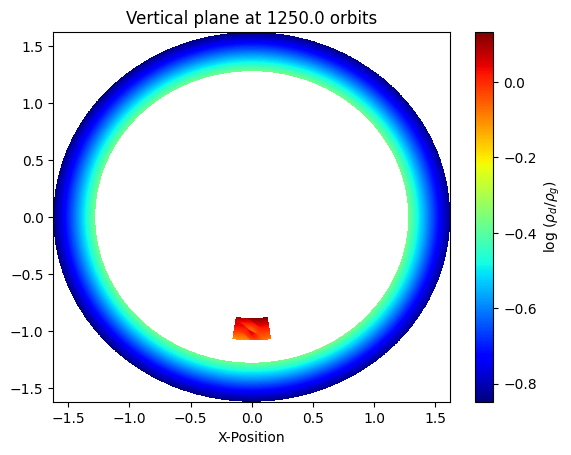

In [ ]:
R, PHI= np.meshgrid(r_f, phi_f)
plt.pcolormesh(R*np.sin(PHI), (R*np.cos(PHI)), v_phi[:,64,:], cmap='jet')
plt.xlabel('X-Position')


plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'log ($\rho_d / \rho_g$)', rotation=90)

In [109]:
data = load_level_gas(500, off=0, adi=True)

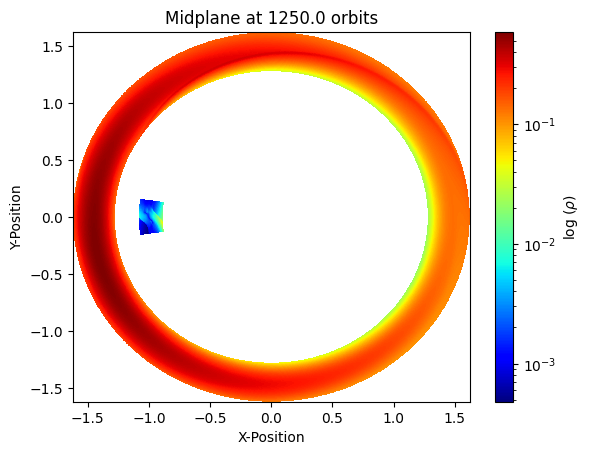

In [213]:
# Find index closest to midplane (theta = pi/2)
midplane_idx = np.argmin(np.abs(theta_c - np.pi/2))
dens_mid = dens[:, 16, :]
R, PHI = np.meshgrid(r_f, phi_f) 
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

plt.pcolormesh(X, Y, dens_mid, cmap='jet', norm='log')
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title(f'Midplane at {round(orbits,1)} orbits')
plt.colorbar(label=r'log ($\rho$)')

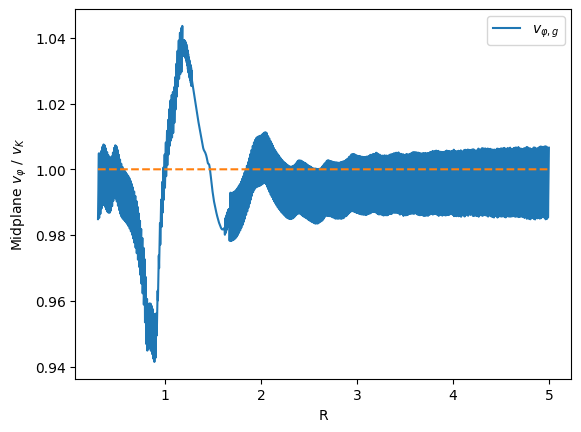

In [18]:
PHI_C, THETA_C, R_C= np.meshgrid(phi_c, theta_c, r_c, indexing='ij')

plt.plot(r_c, ((v_phi+(R_C*1.000477))[1118, 64,:])/(np.sqrt(1.0/r_c)), label = r'$v_{\varphi, g}$')
#plt.plot(r_c, ((v_phi_dust +(R_C*1.000477))[1118, 64,:]) / (np.sqrt(1.0/r_c)), color = 'red', label = r'$v_{\varphi, d}$', linestyle='dashed')
plt.plot(r_c, np.cbrt(1.0/r_c)/np.cbrt(1.0/r_c), linestyle='dashed')

plt.xlabel(r'R')
plt.ylabel(r'Midplane $v_{\varphi}$ / $v_K$')
plt.legend()

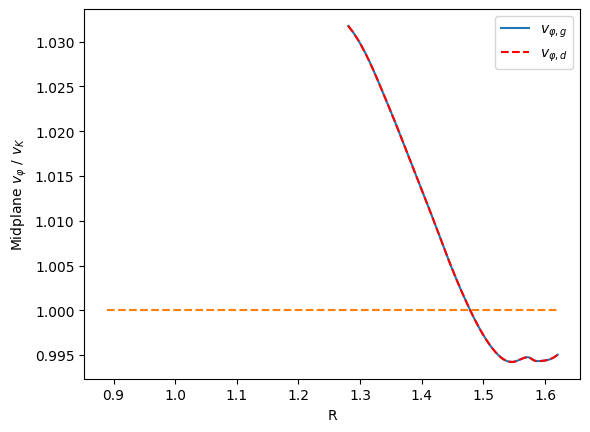

In [231]:
v_phi = data[7]
v_phi_dust = data[-1]

PHI_C, THETA_C, R_C= np.meshgrid(phi_c, theta_c, r_c, indexing='ij')

plt.plot(r_c, ((v_phi+(R_C*1.000477))[199, 16,:])/(np.sqrt(1.0/r_c)), label = r'$v_{\varphi, g}$')
plt.plot(r_c, ((v_phi_dust +(R_C*1.000477))[199, 16,:]) / (np.sqrt(1.0/r_c)), color = 'red', label = r'$v_{\varphi, d}$', linestyle='dashed')
plt.plot(r_c, np.cbrt(1.0/r_c)/np.cbrt(1.0/r_c), linestyle='dashed')


plt.xlabel(r'R')
plt.ylabel(r'Midplane $v_{\varphi}$ / $v_K$')
plt.legend()

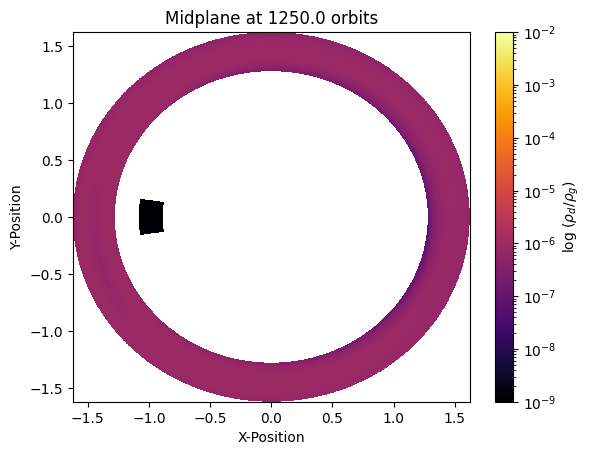

In [229]:
midplane_dust = np.argmin(np.abs(theta_c - np.pi/2))
dens_dust_mid = dust_dens[:, 16, :]
R, PHI = np.meshgrid(r_f, phi_f) 
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

plt.pcolormesh(X, Y, dens_dust_mid/dens_mid, cmap='inferno', norm='log' ,vmin= 1e-9, vmax = 1e-2)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title(f'Midplane at {round(orbits,1)} orbits')
plt.colorbar(label=r'log ($\rho_d$/$\rho_g$)')

TypeError: Dimensions of C (2048, 1536) should be one smaller than X(241) and Y(2049) while using shading='flat' see help(pcolormesh)

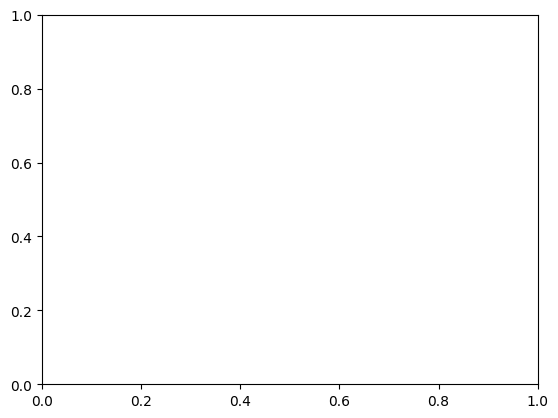

In [ ]:
midplane_stokes = np.argmin(np.abs(theta_c - np.pi/2))
stokes_mid = stokes[:, 16, :]
R, PHI = np.meshgrid(r_f, phi_f) 
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

plt.pcolormesh(X, Y, stokes_mid, cmap='jet', norm='log', vmin=stokes_mid.min())
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title(f'Midplane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \frac{a \rho_s \pi}{\Sigma_g}$', rotation = 0)

In [ ]:
max_dust_to_gas = np.where((dens_mid) == (dens_mid).max())[0][0]
max_dust_to_gas_r = np.where((dens_dust_mid/dens_mid) == (dens_dust_mid/dens_mid).max())[1][0]

NameError: name 'dens_dust_mid' is not defined

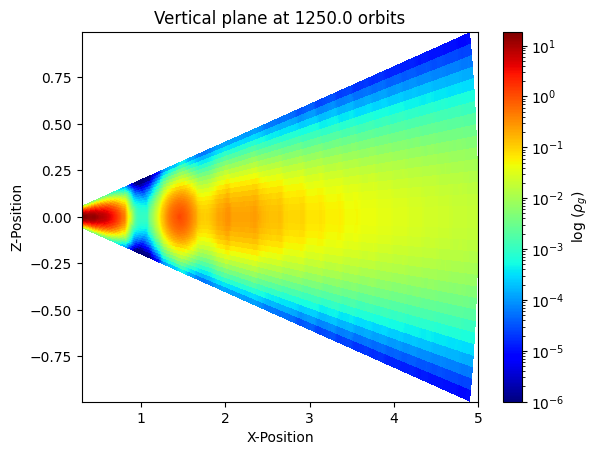

In [7]:
R, THETA= np.meshgrid(r_f, theta_f)
plt.pcolormesh(R*np.sin(THETA), R*np.cos(THETA), dens[max_dust_to_gas], norm = 'log', cmap='jet', vmin = 1e-6, vmax= dens[max_dust_to_gas].max())
plt.xlabel('X-Position')
plt.ylabel('Z-Position')
plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'log ($\rho_g$)', rotation=90)

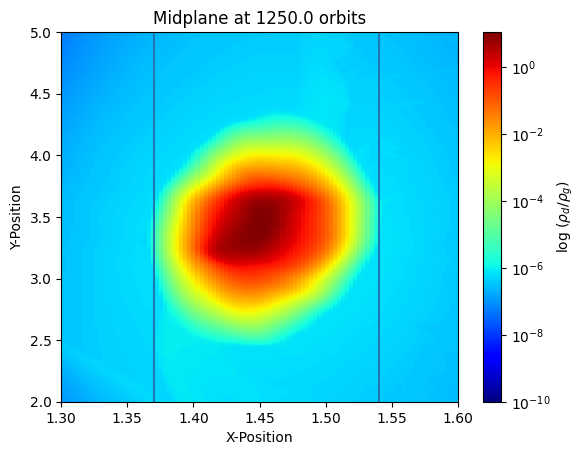

In [5]:
midplane_dust = np.argmin(np.abs(theta_c - np.pi/2))
dens_mid = dens_dust[:, midplane_dust, :]
R, PHI = np.meshgrid(r_f, phi_f) 

plt.pcolormesh(R, PHI, dens_mid, cmap='jet', norm='log', vmin=1e-10, vmax = (dens_mid).max())
plt.xlim(1.3,1.6)
plt.ylim(2,5)

plt.vlines(1.37, 2.0, 5.0)
plt.vlines(1.54, 2.0, 5.0)

plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title(f'Midplane at {round(orbits,1)} orbits')
plt.colorbar(label=r'log ($\rho_d$/$\rho_g$)')

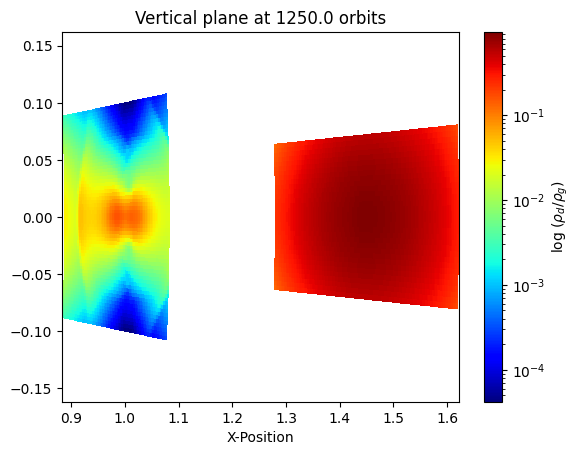

In [163]:
R, THETA= np.meshgrid(r_f, theta_f)
plt.pcolormesh(R*np.sin(THETA), (R*np.cos(THETA)), dens[1022], norm = 'log', cmap='jet')
plt.xlabel('X-Position')


plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'log ($\rho_d / \rho_g$)', rotation=90)

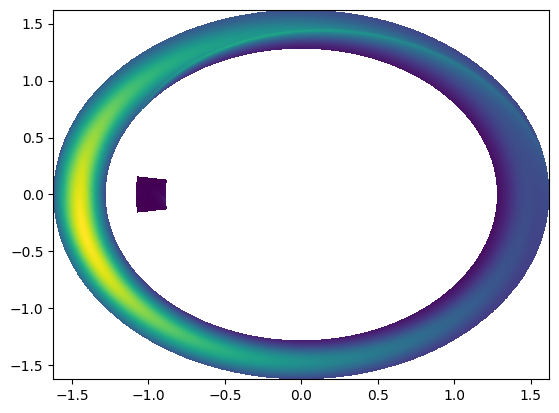

In [161]:
midplane = np.argmin(np.abs(theta_c - np.pi/2))
dens_mid= dens[:, 16, :]
R, PHI = np.meshgrid(r_f, phi_f) 
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

plt.pcolormesh(X, Y ,dens_mid)

In [169]:
R, THETA= np.meshgrid(r_f, theta_f)
plt.pcolormesh(R*np.sin(THETA), (R*np.cos(THETA)), dens_dust[max_dust_to_gas]/dens[max_dust_to_gas], norm = 'log', cmap='jet', vmin=1e-6, vmax = (dens_dust[max_dust_to_gas]/dens[max_dust_to_gas]).max())
plt.xlabel('X-Position')
plt.vlines(1.37, -0.25, 0.25, color='white')
plt.vlines(1.54, -0.25, 0.25, color='white')

plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'log ($\rho_d / \rho_g$)', rotation=90)

ValueError: operands could not be broadcast together with shapes (128,1536) (64,240) 

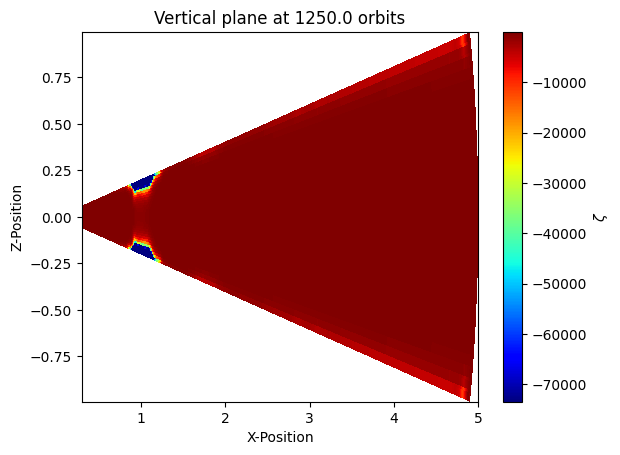

In [11]:
R, THETA = np.meshgrid(r_f, theta_f)
plt.pcolormesh(R*np.sin(THETA), R*np.cos(THETA), vortensity[max_dust_to_gas], cmap='jet', vmin = np.average(vortensity[max_dust_to_gas], axis = 1).min())
plt.xlabel('X-Position')
plt.ylabel('Z-Position')
plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\zeta$', rotation=90)

In [12]:
R, PHI= np.meshgrid(r_c, phi_c)  

v_K = np.sqrt(1.0 / R)
omega_K = np.sqrt(1.0 / R**3)
delta_v_phi = v_phi[:, np.argmin(np.abs(theta_c - np.pi/2)), :] - v_K - (R*0.000477)  

term1 = np.gradient(R * delta_v_phi, r_c, axis=1) / R
term2 = np.gradient(v_r[:, np.argmin(np.abs(theta_c - np.pi/2)), :], phi_c, axis=0) / R
curl_g = term1 - term2

# Rossby number
Rossby = 2.0 * curl_g / omega_K

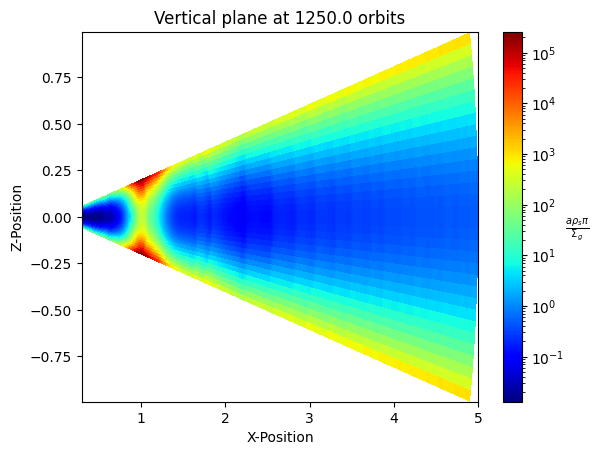

In [13]:
R, THETA = np.meshgrid(r_f, theta_f)
plt.pcolormesh(R*np.sin(THETA), R*np.cos(THETA), stokes[0], norm='log', cmap='jet', vmin = stokes.min())
plt.xlabel('X-Position')
plt.ylabel('Z-Position')
plt.title(f'Vertical plane at {round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \frac{a \rho_s \pi}{\Sigma_g}$', rotation = 0)

Text(0.5, 1.0, 'Midplane plane at 1250.0 orbits')

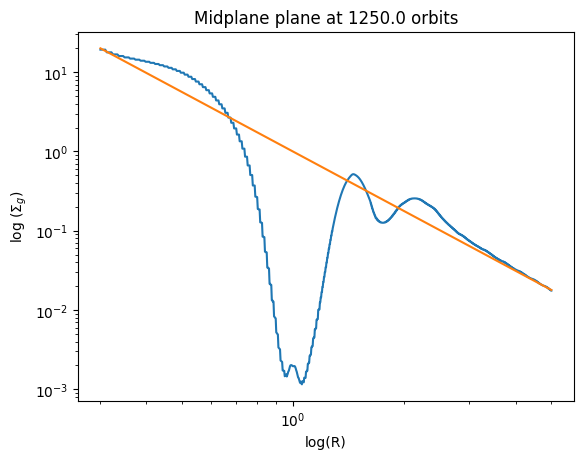

In [14]:
plt.plot(r_c, np.average(dens_mid, axis=0))
plt.plot(r_c, r_c**(-2.5))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log(R)')
plt.ylabel(r'log ($\Sigma_g$)')

plt.title(f'Midplane plane at {round(orbits,1)} orbits')

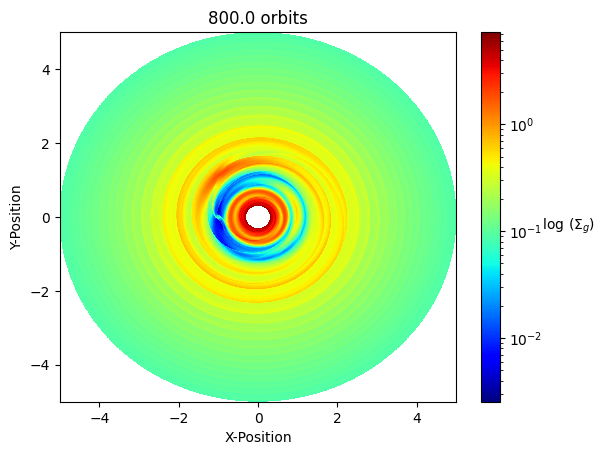

In [787]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), (dens), norm = 'log', cmap='jet', vmin = (dens).min(), vmax = dens.max())

plt.xlabel('X-Position')
plt.ylabel('Y-Position')

plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, $ log ($\Sigma_g$)', rotation=0)

In [485]:
r_c[337]

np.float64(1.3327154411611122)

In [494]:
np.where(r_c >1.64)

(array([ 438,  439,  440,  441,  442,  443,  444,  445,  446,  447,  448,
         449,  450,  451,  452,  453,  454,  455,  456,  457,  458,  459,
         460,  461,  462,  463,  464,  465,  466,  467,  468,  469,  470,
         471,  472,  473,  474,  475,  476,  477,  478,  479,  480,  481,
         482,  483,  484,  485,  486,  487,  488,  489,  490,  491,  492,
         493,  494,  495,  496,  497,  498,  499,  500,  501,  502,  503,
         504,  505,  506,  507,  508,  509,  510,  511,  512,  513,  514,
         515,  516,  517,  518,  519,  520,  521,  522,  523,  524,  525,
         526,  527,  528,  529,  530,  531,  532,  533,  534,  535,  536,
         537,  538,  539,  540,  541,  542,  543,  544,  545,  546,  547,
         548,  549,  550,  551,  552,  553,  554,  555,  556,  557,  558,
         559,  560,  561,  562,  563,  564,  565,  566,  567,  568,  569,
         570,  571,  572,  573,  574,  575,  576,  577,  578,  579,  580,
         581,  582,  583,  584,  585, 

In [467]:
r_c[392]

np.float64(1.5010096264401191)

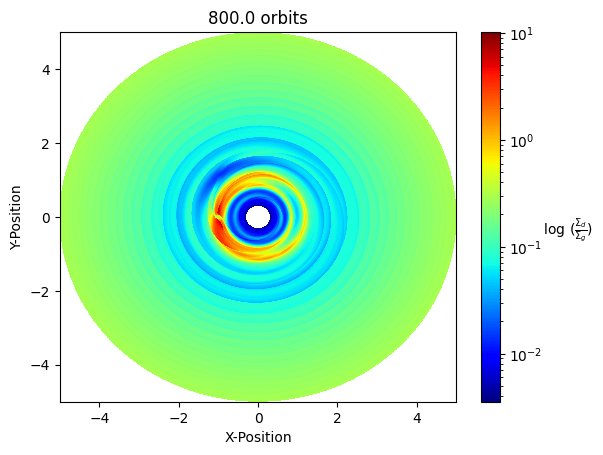

In [898]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), stokes, norm = 'log', cmap='jet', vmin = stokes.min(), vmax = stokes.max())
plt.xlabel('X-Position')
plt.ylabel('Y-Position')

plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, $ log ($\frac{\Sigma_d}{\Sigma_g}$)', rotation=0)

In [551]:
(dens_dust/dens).max()

np.float32(117.30863)

(0.3, 0.8)

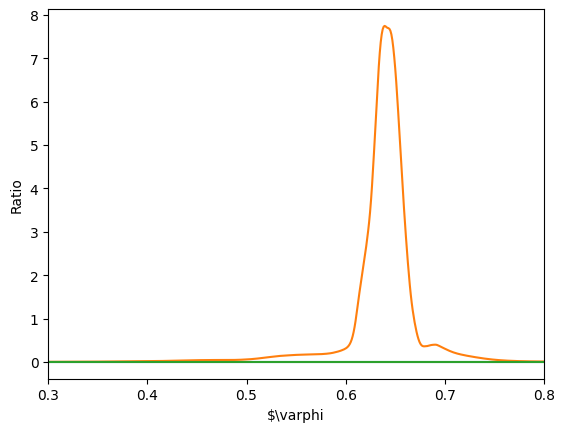

In [565]:
plt.plot(phi_c/np.pi, (dens_dust/dens)[:, 336])
plt.plot(phi_c/np.pi, (dens_dust/dens)[:, 392])
plt.plot(phi_c/np.pi, (dens_dust/dens)[:, 438])

plt.xlabel(r'$\varphi')
plt.ylabel('Ratio')
plt.xlim(0.3,0.8)

Text(0.5, 1.0, '800.0 orbits')

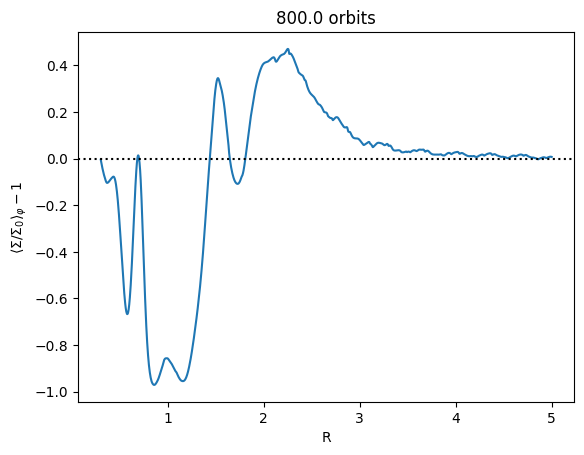

In [1015]:
plt.plot(r_c, np.average(dens/ (r_c**(-1.5)), axis = 0) -1)
plt.xlabel('R')
plt.ylabel(r'$\langle \Sigma / \Sigma_0 \rangle_{\varphi} - 1$')


plt.axhline(y=0, linestyle='dotted', color='black')
plt.title(f'{np.round(orbits,1)} orbits')

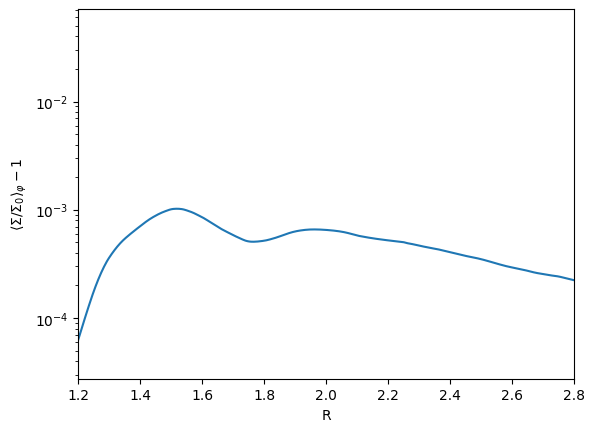

In [ ]:
plt.plot(r_c, np.average(press, axis = 0))
plt.xlabel('R')
plt.ylabel(r'$\langle \Sigma / \Sigma_0 \rangle_{\varphi} - 1$')
plt.yscale('log')
plt.xlim(1.2, 1.0)
plt.axhline(y=0, linestyle='dotted', color='black')

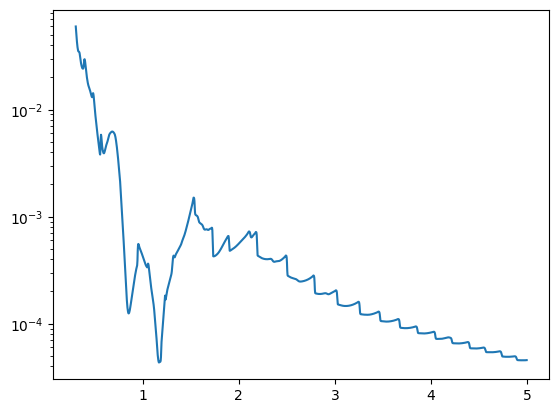

In [789]:
plt.plot(r_c, press[336])
plt.yscale('log')


In [557]:
vortex_index = np.where(stokes[:, r_c > 1.0] == stokes[:, r_c > 1.0].min())[0][0]
vortex_index_r = np.where(stokes[:, r_c > 1.2] == stokes[:, r_c > 1.2].min())[1][0]

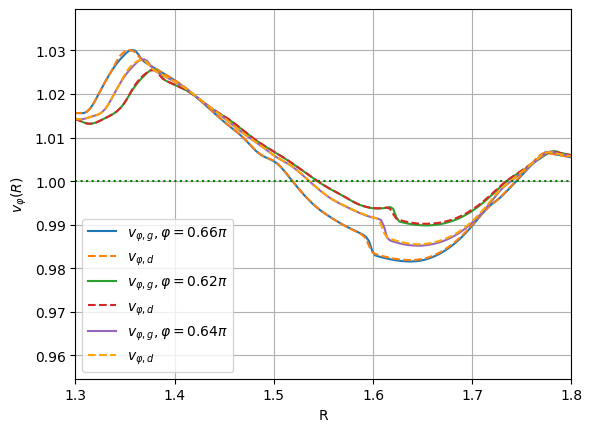

In [945]:
plt.plot(r_c, (v_phi+(R_C*1.0005))[676]/np.sqrt(1.0/r_c), label= r'$v_{\varphi, g}, \varphi = 0.66 \pi$')
plt.plot(r_c, (v_phi_dust + (R_C*1.0005))[676]/np.sqrt(1.0/r_c), linestyle='dashed', label= r'$v_{\varphi, d}$')

plt.plot(r_c, (v_phi+(R_C*1.0005))[635]/np.sqrt(1.0/r_c), label= r'$v_{\varphi, g}, \varphi = 0.62 \pi$')
plt.plot(r_c, (v_phi_dust + (R_C*1.0005))[635]/np.sqrt(1.0/r_c), linestyle='dashed', label= r'$v_{\varphi, d}$')


plt.plot(r_c, (v_phi+(R_C*1.0005))[655]/np.sqrt(1.0/r_c), label= r'$v_{\varphi, g}, \varphi = 0.64 \pi$')
plt.plot(r_c, (v_phi_dust + (R_C*1.0005))[655]/np.sqrt(1.0/r_c), linestyle='dashed', label= r'$v_{\varphi, d}$', color='orange')
plt.plot(r_c, np.sqrt(1.0/r_c)/np.sqrt(1.0/r_c), linestyle = 'dotted', color='green')

plt.grid()

plt.xlim(1.3, 1.8)

plt.xlabel('R')

plt.ylabel(r'$v_{\varphi} (R) $')
plt.legend()

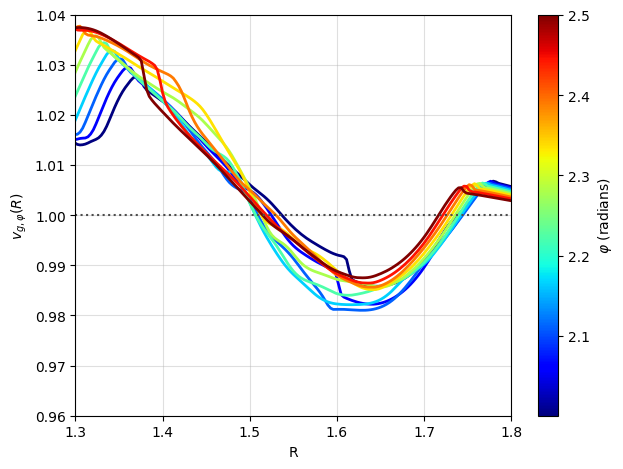

In [946]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

# ---- choose 10 indices between 635 and 676 (inclusive) ----
indices = [int(round(x)) for x in np.linspace(652, 815, 10)]

# ---- azimuthal angle for each index ----
# If you already have an array of azimuths per index, use it:
#   phi_grid = your_phi_array  # shape (Nphi,), radians
# Otherwise, assume uniform grid in φ from the data shape:
phi_grid = np.linspace(0, 2*np.pi, v_phi.shape[0], endpoint=False)

phis = phi_grid[indices]

# ---- continuous colormap in φ ----
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=phis.min(), vmax=phis.max())

for idx, phi in zip(indices, phis):
    color = cmap(norm(phi))

    yg = (v_phi + (R_C*1.000477))[idx] / np.sqrt(1.0 / r_c)          # gas

    # same color for a given φ; solid=gas, dashed=dust
    ax.plot(r_c, yg, lw=2, color=color)

# reference Keplerian line
ax.plot(r_c, np.sqrt(1.0/r_c)/np.sqrt(1.0/r_c), ls=':', color='0.3')

# colorbar encodes φ continuously (label in π units)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\varphi\ \mathrm{(radians)}$')

# tidy plot
ax.grid(True, alpha=0.4)
ax.set_xlim(1.3, 1.8)
ax.set_ylim(0.96, 1.04)
ax.set_xlabel('R')
ax.set_ylabel(r'$v_{g, \varphi}(R)$')

plt.tight_layout()
plt.show()


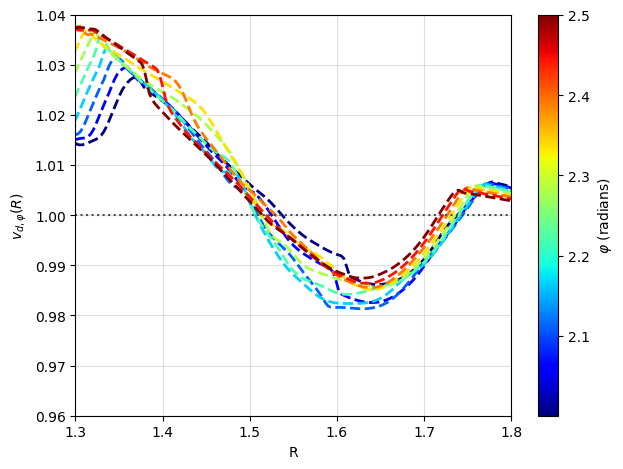

In [947]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

# ---- choose 10 indices between 635 and 676 (inclusive) ----
indices = [int(round(x)) for x in np.linspace(652, 815, 10)]

# ---- azimuthal angle for each index ----
# If you already have an array of azimuths per index, use it:
#   phi_grid = your_phi_array  # shape (Nphi,), radians
# Otherwise, assume uniform grid in φ from the data shape:
phi_grid = np.linspace(0, 2*np.pi, v_phi.shape[0], endpoint=False)

phis = phi_grid[indices]

# ---- continuous colormap in φ ----
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=phis.min(), vmax=phis.max())

for idx, phi in zip(indices, phis):
    color = cmap(norm(phi))

    yd = (v_phi_dust + (R_C*1.000477))[idx] / np.sqrt(1.0 / r_c)          # dust

    # same color for a given φ; solid=gas, dashed=dust
    ax.plot(r_c, yd, lw=2, color=color, linestyle='dashed')

# reference Keplerian line
ax.plot(r_c, np.sqrt(1.0/r_c)/np.sqrt(1.0/r_c), ls=':', color='0.3')

# colorbar encodes φ continuously (label in π units)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\varphi\ \mathrm{(radians)}$')

# tidy plot
ax.grid(True, alpha=0.4)
ax.set_xlim(1.3, 1.8)
ax.set_ylim(0.96, 1.04)
ax.set_xlabel('R')
ax.set_ylabel(r'$v_{d, \varphi}(R)$')

plt.tight_layout()
plt.show()

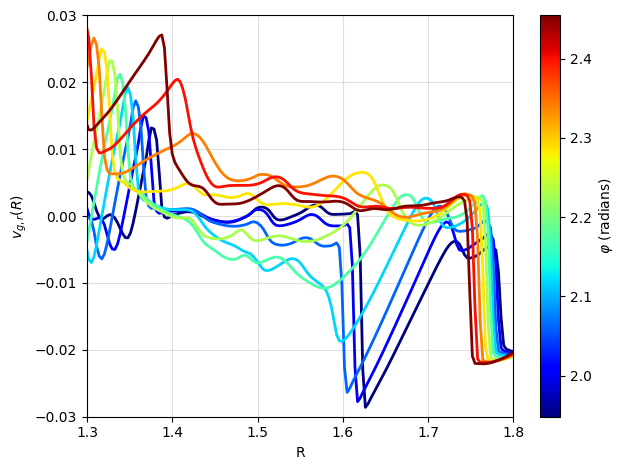

In [948]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

# ---- choose 10 indices between 635 and 676 (inclusive) ----
indices = [int(round(x)) for x in np.linspace(635, 800, 10)]


phi_grid = np.linspace(0, 2*np.pi, v_phi.shape[0], endpoint=False)

phis = phi_grid[indices]

# ---- continuous colormap in φ ----
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=phis.min(), vmax=phis.max())

for idx, phi in zip(indices, phis):
    color = cmap(norm(phi))

    yg = (v_r)[idx]        # dust

    # same color for a given φ; solid=gas, dashed=dust
    ax.plot(r_c, yg, lw=2, color=color)

# colorbar encodes φ continuously (label in π units)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\varphi\ \mathrm{(radians)}$')

# tidy plot
ax.grid(True, alpha=0.4)
ax.set_xlim(1.3, 1.8)
ax.set_ylim(-0.03, 0.03)

ax.set_xlabel('R')
ax.set_ylabel(r'$v_{g, r}(R)$')

plt.tight_layout()
plt.show()

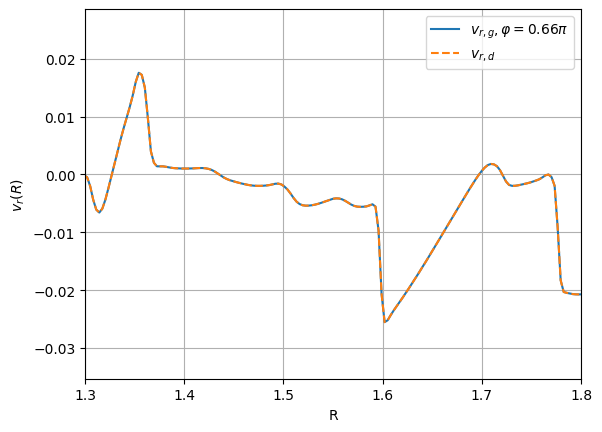

In [ ]:
'''plt.plot(r_c, (v_r)[676], label= r'$v_{r, g}, \varphi = 0.66 \pi$')
plt.plot(r_c, (v_r)[676], linestyle='dashed', label= r'$v_{r, d}$')'''

plt.plot(r_c, (v_r)[635], label= r'$v_{r, g}, \varphi = 0.62 \pi$')
plt.plot(r_c, (v_r)[635], linestyle='dashed', label= r'$v_{r, d}$')


plt.plot(r_c, (v_r)[655], label= r'$v_{r, g}, \varphi = 0.64 \pi$')
plt.plot(r_c, (v_r)[655], linestyle='dashed', label= r'$v_{r, d}$', color='orange')

plt.grid()

plt.xlim(1.3, 1.8)

plt.xlabel('R')

plt.ylabel(r'$v_{r} (R) $')
plt.legend()

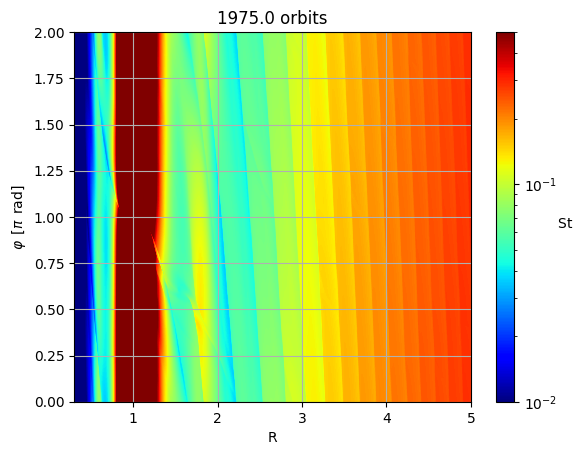

In [5]:
R, PHI = np.meshgrid(r_f, phi_f)
plt.pcolormesh(R, PHI/np.pi, stokes, norm = 'log', cmap='jet', vmin = 0.01, vmax = 0.5)
plt.xlabel('R')
plt.ylabel(r'$\varphi\, $ [$\pi \,$ rad]')


plt.grid()


plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\,$ St', rotation = 0)

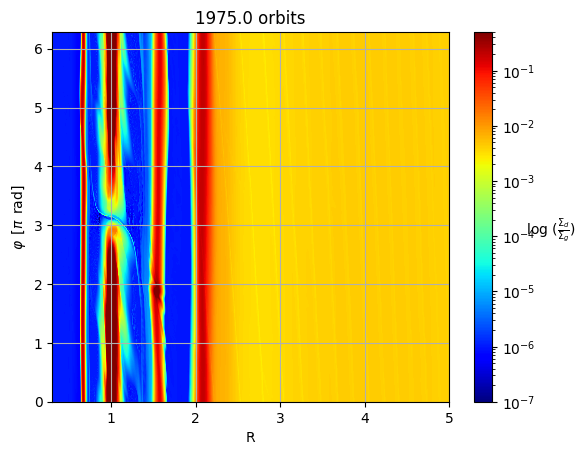

In [13]:
R_C, PHI_C = np.meshgrid(r_c, phi_c)
R, PHI = np.meshgrid(r_f, phi_f)
plt.pcolormesh(R, PHI, (dens_dust/dens), norm = 'log', cmap='jet', vmin = 1e-7, vmax = 0.5)
plt.xlabel('R')
plt.ylabel(r'$\varphi\, $ [$\pi \,$ rad]')
'''plt.xlim(1.35,1.65)
plt.ylim(0.4*np.pi, 1.2*np.pi)'''

plt.grid()



plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \,$ log $(\frac{\Sigma_d}{\Sigma_g})$', rotation = 0)


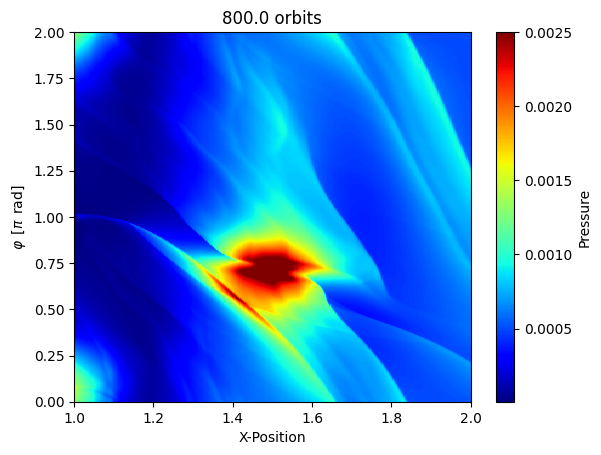

In [968]:
R, PHI = np.meshgrid(r_f, phi_f)
plt.pcolormesh(R, PHI/np.pi, press, cmap='jet', vmin= press.min(), vmax = 0.0025)
plt.xlabel('X-Position')
plt.ylabel(r'$\varphi\, $ [$\pi \,$ rad]')
plt.xlim(1,2)
#plt.ylim(0.25, 1.25)


plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'Pressure')

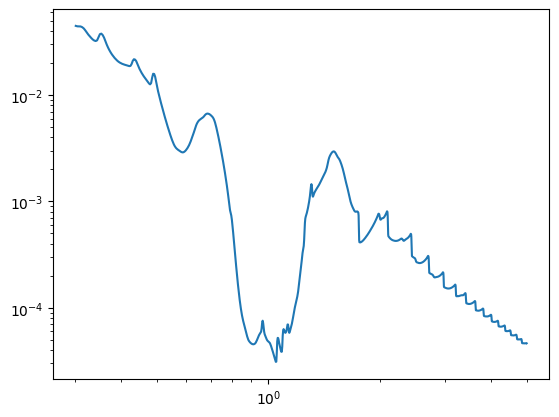

In [944]:
phi_c[768]
plt.plot(r_c, press[768])
plt.yscale('log')
plt.xscale('log')

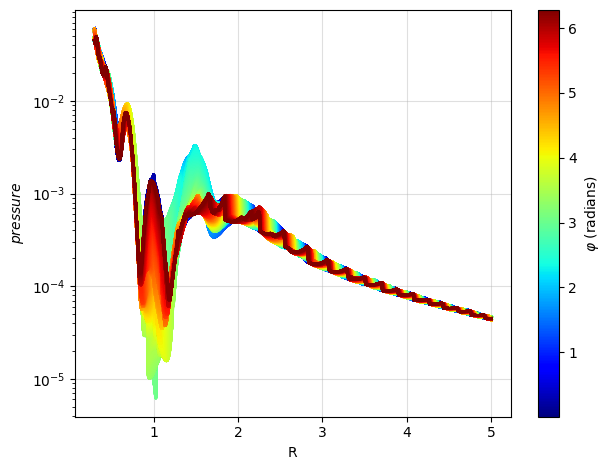

In [1014]:
fig, ax = plt.subplots()

# ---- choose 10 indices between 635 and 676 (inclusive) ----
indices = [int(round(x)) for x in np.linspace(1, 2047, 5000)]


phi_grid = np.linspace(0, 2*np.pi, v_phi.shape[0], endpoint=False)

phis = phi_grid[indices]

# ---- continuous colormap in φ ----
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=phis.min(), vmax=phis.max())

for idx, phi in zip(indices, phis):
    color = cmap(norm(phi))

    yg = (press)[idx]        # dust

    # same color for a given φ; solid=gas, dashed=dust
    ax.plot(r_c, yg, lw=2, color=color)

# colorbar encodes φ continuously (label in π units)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\varphi\ \mathrm{(radians)}$')

# tidy plot
ax.grid(True, alpha=0.4)
#ax.set_xlim(1.15, 1.835)
#ax.set_ylim(1e-4, 1e-2)
ax.set_yscale('log')

ax.set_xlabel('R')
ax.set_ylabel(r'$pressure$')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(r_c, np.average(dens/ (r_c**(-1.5)), axis = 0) -1)
plt.xlabel('R')
plt.ylabel(r'$\langle \Sigma / \Sigma_0 \rangle_{\varphi} - 1$')




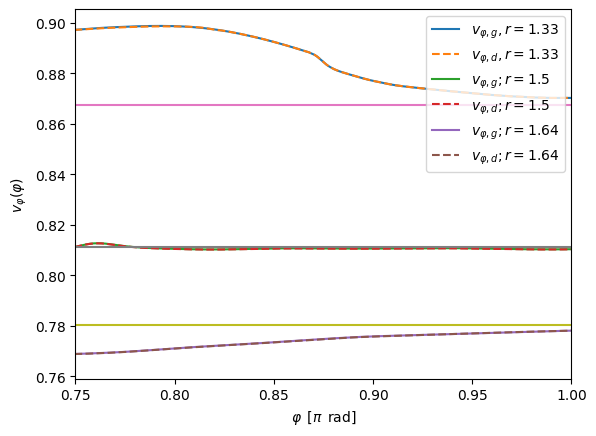

In [1008]:
v_K = np.sqrt(1.0/ R_C)

plt.plot(phi_c/np.pi, (v_phi + (R_C * 1.000477))[:, 336], label= r'$v_{\varphi, g}, r = 1.33$')
plt.plot(phi_c/np.pi, (v_phi_dust + (R_C * 1.000477))[:, 336], linestyle = 'dashed', label= r'$v_{\varphi, d}, r = 1.33$')

plt.plot(phi_c/np.pi, (v_phi + (R_C * 1.000477))[:, 398], label= r'$v_{\varphi, g}; r = 1.5$')
plt.plot(phi_c/np.pi, (v_phi_dust + (R_C * 1.000477))[:, 398], linestyle = 'dashed', label= r'$v_{\varphi, d}; r = 1.5$')

plt.plot(phi_c/np.pi, (v_phi + (R_C * 1.000477))[:, 438], label= r'$v_{\varphi, g}; r = 1.64$')
plt.plot(phi_c/np.pi, (v_phi_dust + (R_C * 1.000477))[:, 438], linestyle = 'dashed', label= r'$v_{\varphi, d}; r = 1.64$')

plt.plot(phi_c/np.pi, v_K[:, 336])
plt.plot(phi_c/np.pi, v_K[:, 398])
plt.plot(phi_c/np.pi, v_K[:, 438])

plt.xlim(0.75,1.0)

plt.ylabel(r'$v_{\varphi} (\varphi)$')
plt.xlabel(r'$\varphi\, $ [$\pi \,$ rad]')
plt.legend()

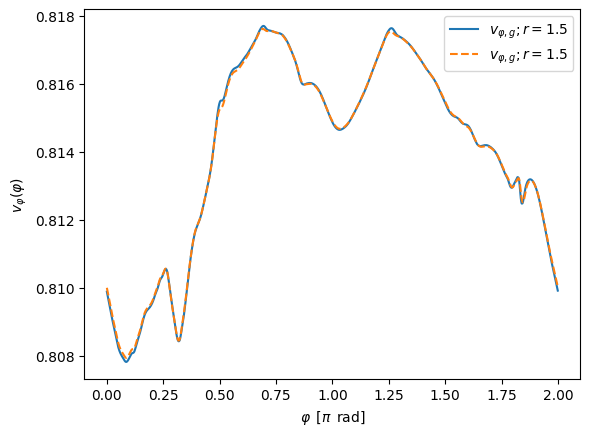

In [493]:
plt.plot(phi_c/np.pi, (v_phi + (R_C * 1.000477))[:, 392], label= r'$v_{\varphi, g}; r = 1.5$')
plt.plot(phi_c/np.pi, (v_phi_dust + (R_C * 1.000477))[:, 392], linestyle = 'dashed', label= r'$v_{\varphi, g}; r = 1.5$')

plt.ylabel(r'$v_{\varphi} (\varphi)$')
plt.xlabel(r'$\varphi\, $ [$\pi \,$ rad]')
plt.legend()

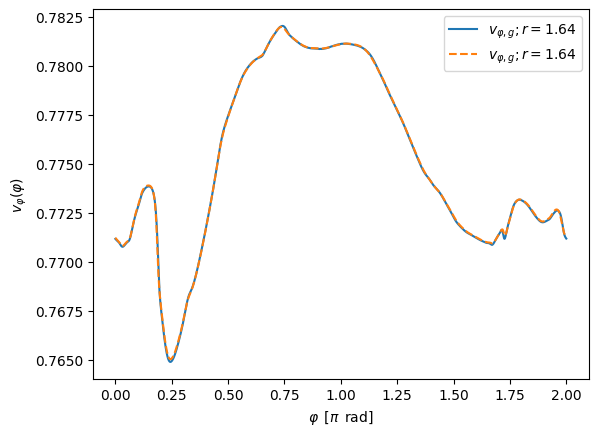

In [495]:
plt.plot(phi_c/np.pi, (v_phi + (R_C * 1.000477))[:, 438], label= r'$v_{\varphi, g}; r = 1.64$')
plt.plot(phi_c/np.pi, (v_phi_dust + (R_C * 1.000477))[:, 438], linestyle = 'dashed', label= r'$v_{\varphi, g}; r = 1.64$')

plt.ylabel(r'$v_{\varphi} (\varphi)$')
plt.xlabel(r'$\varphi\, $ [$\pi \,$ rad]')
plt.legend()

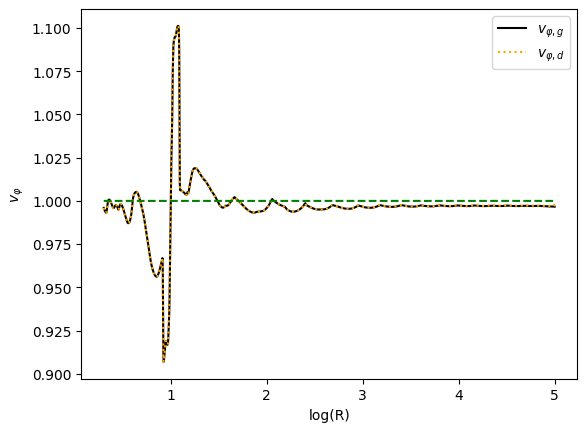

In [355]:
plt.plot(r_c, (v_phi+(R_C*1.000477))[1023]/np.sqrt(1.0/r_c), label= r'$v_{\varphi, g}$', color='black')
plt.plot(r_c, (v_phi_dust + (R_C*1.000477))[1023]/np.sqrt(1.0/r_c), linestyle='dotted', label= r'$v_{\varphi, d}$', color='orange')
plt.plot(r_c, np.sqrt(1.0/r_c)/np.sqrt(1.0/r_c), linestyle = 'dashed', color='green')

plt.xlabel('log(R)')

plt.ylabel(r'$v_{\varphi}$')
plt.legend()

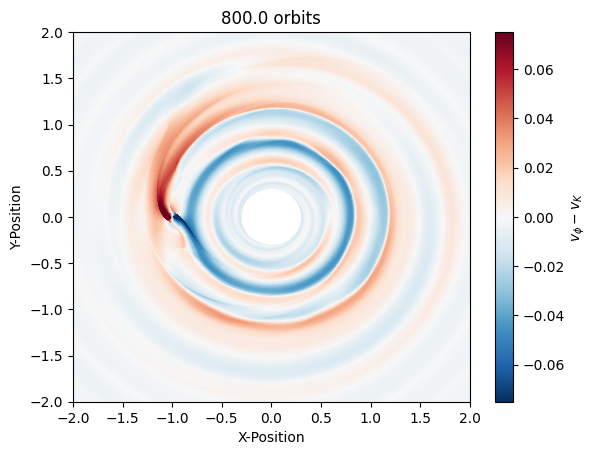

In [880]:
R, PHI = np.meshgrid(r_f, phi_f)
R_C, PHI_C = np.meshgrid(r_c, phi_c)
plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), (v_phi+(R_C*1.000477)) - v_K, cmap='RdBu_r', vmin = -0.075, vmax=0.075)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$v_{\phi} - v_K$', rotation=90)

$$R_o = \frac{2 [\vec{\nabla} \times (\vec{v}_g - v_K)]_z}{\Omega_K}$$

In [366]:
R, PHI= np.meshgrid(r_c, phi_c)  # shape: (Nphi, Nr)

v_K = np.sqrt(1.0 / R)
omega_K = np.sqrt(1.0 / R**3)
delta_v_phi = (v_phi + (R*1.000477)) - v_K # both are 2D

term1 = np.gradient(R * delta_v_phi, r_c, axis=1) / R
term2 = np.gradient(v_r, phi_c, axis=0) / R
curl_g = term1 - term2

# Rossby number
Rossby = 2.0 * curl_g / omega_K

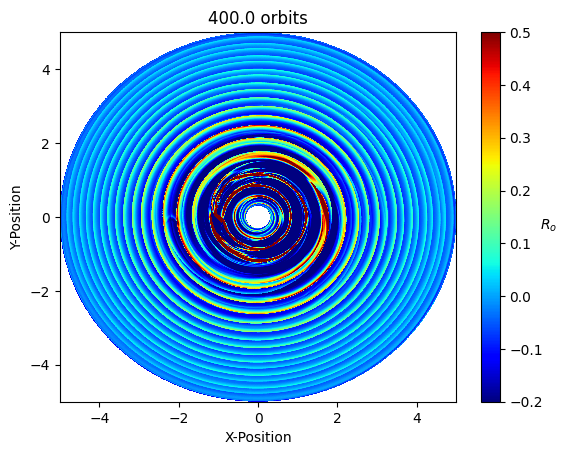

In [374]:
R, PHI = np.meshgrid(r_f, phi_f)
plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), Rossby, cmap='jet', vmin=-0.2 , vmax = 0.5)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')

plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$R_o$', rotation=0)

In [365]:
Rossby.max()

np.float64(42.79089911511346)

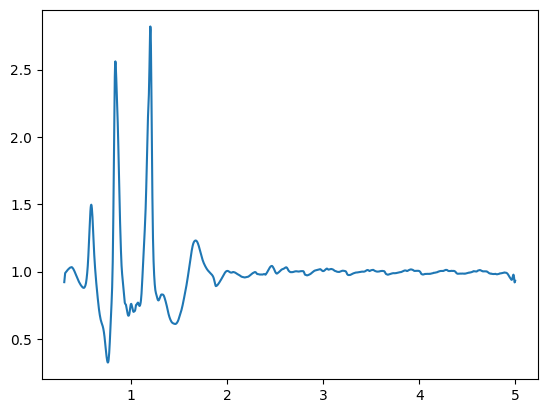

In [ ]:
plt.plot(r_c, Rossby)

Text(0.5, 1.0, '750.0 orbits')

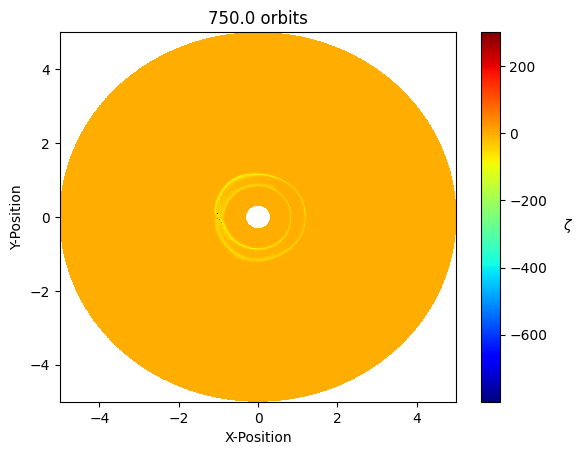

In [321]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), vortensity, cmap='jet')
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, $ $\zeta$', rotation=0)
plt.title(f'{np.round(orbits,1)} orbits')

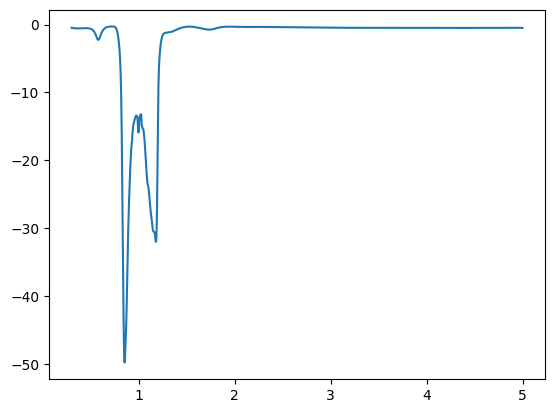

In [862]:
plt.plot(r_c, np.average(vortensity, axis=0))

Text(0.5, 1.0, '800.0 orbits')

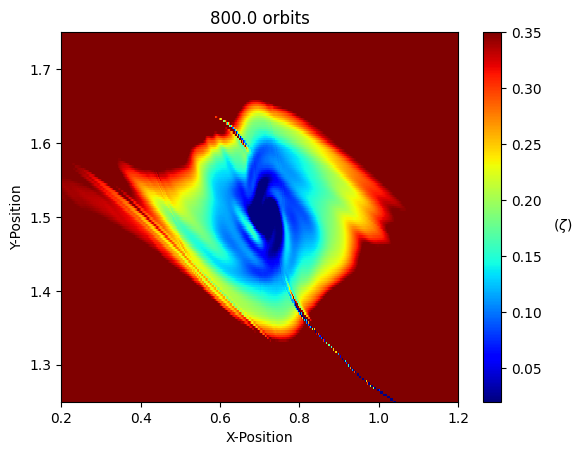

In [1007]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(PHI/np.pi, R, -1*vortensity, cmap='jet', vmin = 0.02, vmax = 0.35)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.ylim(1.25, 1.75)
plt.xlim(0.2, 1.2)

plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, $ ($\zeta$)', rotation=0)
plt.title(f'{np.round(orbits,1)} orbits')

#plt.text(0.015, 2.4, f'{np.round(orbits, 1)} orbits', color='red')

(-2.0, 2.0)

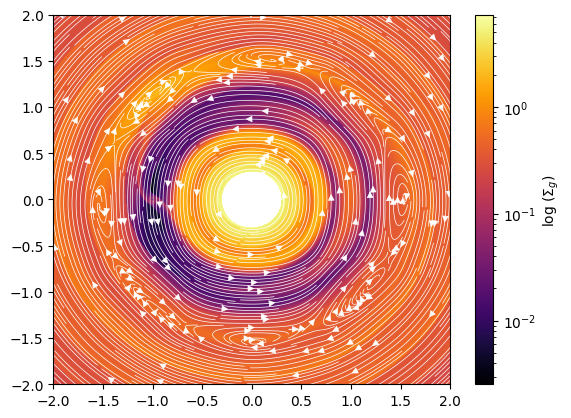

In [845]:
from scipy.interpolate import *
R_C, PHI_C = np.meshgrid(r_c, phi_c)
X_C, Y_C = R_C * np.cos(PHI_C), R_C * np.sin(PHI_C)
R, PHI = np.meshgrid(r_f, phi_f)
X, Y = R*np.cos(PHI), R*np.sin(PHI)

v_phi_prime = v_phi - (R_C*(-0.477))
v_x = v_r * np.cos(PHI_C) - v_phi_prime * np.sin(PHI_C)
v_y = v_r * np.sin(PHI_C) + v_phi_prime * np.cos(PHI_C)

nx, ny = 15, 15

x_lin = np.linspace(X_C.min(), X_C.max(), nx)
y_lin = np.linspace(Y_C.min(), Y_C.max(), ny)
X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

points = np.column_stack([X_C.ravel(), Y_C.ravel()])
V_X = griddata(points, v_x.ravel(), (X_grid, Y_grid), method='linear')
V_Y = griddata(points, v_y.ravel(), (X_grid, Y_grid), method = 'linear')

plt.pcolormesh(X, Y, (dens), norm = 'log', cmap='inferno', vmin = (dens).min(), vmax = dens.max())
plt.colorbar().set_label(r'log ($\Sigma_g$)')
plt.streamplot(X_grid, Y_grid, V_X, V_Y, density = 10, color='white', linewidth = 0.5)
plt.xlim(-2.0, 2.0)
plt.ylim(-2,2)

(0.7, 1.5)

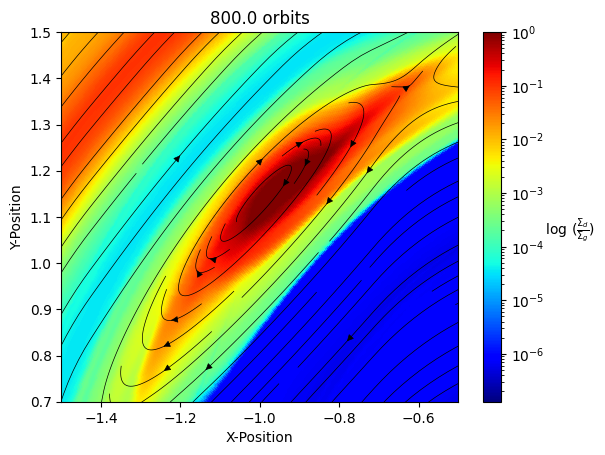

In [851]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), (dens_dust/dens), norm = 'log', cmap='jet', vmin = (dens_dust/dens).min(), vmax = 1)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')


plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, $ log ($\frac{\Sigma_d}{\Sigma_g}$)', rotation=0)

plt.streamplot(X_grid, Y_grid, V_X, V_Y, density = 12.0, color='black', linewidth = 0.5)
plt.xlim(-1.5, -0.5)
plt.ylim(0.7,1.5)

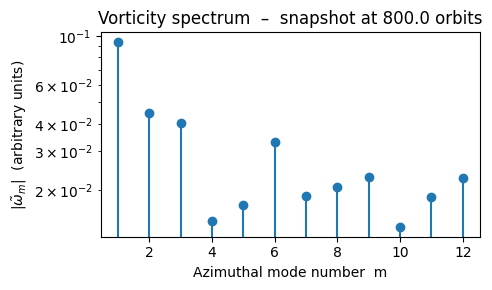

m =  1:  |ω̃_m| = 9.427e-02
m =  2:  |ω̃_m| = 4.498e-02
m =  3:  |ω̃_m| = 4.052e-02


In [886]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ---------------------------------------------------------------
# USER SETTINGS --------------------------------------------------
r_min, r_max = 0.95, 1.15     # annulus that captures the gap-edge vortex
m_max        = 12             # highest azimuthal mode to keep
# ---------------------------------------------------------------

# 0.  Make sure arrays are (phi, r) and cell-centred ----------------
# Athena++ dumps are usually indexed as (var, k, j, i) = (var, phi, theta, r)
# You've already selected the mid-plane slice, so shapes should be (Nφ, Nr)
phi = phi_c                    # (Nφ,) cell centres
r   = r_c                      # (Nr,)  cell centres

# 1.  Compute vertical vorticity ω_z = (1/r) d(r vφ)/dr − (1/r) dv_r/dφ -----
#     (central finite differences on the stagger-free cell-centred grid)
#     First term: (1/r) ∂(r vφ)/∂r
d_r_vphi = np.gradient(r * v_phi, r, axis=1) / r   # axis 1 = radial

#     Second term: (1/r) ∂v_r/∂φ
dphi_vr  = np.gradient(v_r, phi, axis=0) / r       # axis 0 = azimuth

omega = d_r_vphi - dphi_vr                         # (Nφ, Nr)

# 2.  Remove axisymmetric component ------------------------------------------------
omega_prime = omega - omega.mean(axis=0, keepdims=True)

# 3.  Restrict to radial band that contains the vortex ------------------------------
annulus = (r >= r_min) & (r <= r_max)
omega_band = omega_prime[:, annulus]               # (Nφ, Nr_sel)
r_band    = r[annulus]

# 4.  FFT along φ for each r --------------------------------------------------------
fft_phi = np.fft.rfft(omega_band, axis=0) / omega_band.shape[0]  # normalised

# 5.  Weight-average over r to get one amplitude per m -----------------------------
weights = r_band                                   # simple mass-like weight
A_m = np.abs(fft_phi[:m_max+1, :] @ weights) / weights.sum()     # (m_max+1,)

# 6.  Plot -------------------------------------------------------------------------
m_vals = np.arange(m_max+1)
plt.figure(figsize=(5,3))
plt.stem(m_vals[1:], A_m[1:], basefmt=" ")
plt.yscale('log'); plt.xlabel('Azimuthal mode number  m')
plt.ylabel(r'$|\tilde\omega_m|$  (arbitrary units)')
plt.title(f'Vorticity spectrum  –  snapshot at {orbits:.1f} orbits')
plt.tight_layout()
plt.show()

# 7.  Inspect dominant modes -------------------------------------------------------
for m in np.argsort(A_m[1:])[::-1][:3] + 1:
    print(f"m = {m:2d}:  |ω̃_m| = {A_m[m]:.3e}")


/var/folders/5p/4tzq8qks7vl7h9060fc7vw2w001d4r/T/ipykernel_52864/2196022895.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X_C, Y_C, (dens), norm = 'log', cmap='seismic', vmin = (dens).min(), vmax = dens.max())


(-3.0, 3.0)

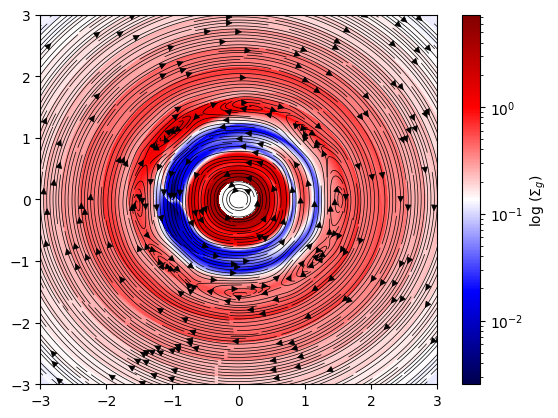

In [852]:
plt.pcolormesh(X_C, Y_C, (dens), norm = 'log', cmap='seismic', vmin = (dens).min(), vmax = dens.max())
plt.colorbar().set_label(r'log ($\Sigma_g$)')
plt.streamplot(X_grid, Y_grid, V_X, V_Y, density = 7, color='black', linewidth = 0.5)
plt.xlim(-3.0, 3.0)
plt.ylim(-3,3)

In [ ]:
np.shape(X_grid)

In [ ]:
rho_s = 1.6        # g/cm^3 (solid density of grains)
a = 2.0            # cm (grain size, modify as needed)
Sigma = dens       # surface density from your simulation, shape (phi, r)

t_s = (np.pi * rho_s * a) / (2.0 * Sigma)  # shape (phi, r)
stokes = omega_K * t_s

In [ ]:
plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), stokes)
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def compute_rossby_number(v_r, v_phi, r_c, phi_c):
    # Meshgrid in (phi, r) ordering: shape (2048, 1536)
    PHI, R = np.meshgrid(phi_c, r_c, indexing='ij')  # PHI: (2048, 1536), R: (2048, 1536)

    # Compute Keplerian azimuthal velocity and angular velocity
    v_K = np.sqrt(1.0 / R)
    Omega_K = np.sqrt(1.0 / R**3)

    # Relative azimuthal velocity
    delta_v_phi = v_phi - v_K

    # Coordinate grid spacing
    dphi = phi_c[1] - phi_c[0]
    dr = r_c[1] - r_c[0]

    # Compute cylindrical curl (z-component of vorticity)
    term1 = np.gradient(R * delta_v_phi, dr, axis=1) / R  # d/dR (R * delta_v_phi)
    term2 = np.gradient(v_r, dphi, axis=0) / R            # d/dphi (v_r)
    omega_z = term1 - term2

    # Rossby number
    Rossby = 2.0 * omega_z / Omega_K

    return Rossby, R, PHI


In [ ]:
Rossby, R, PHI = compute_rossby_number(v_r, v_phi, r_c, phi_c)

# Cartesian projection for plotting
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Plot with centered colormap
plt.figure(figsize=(6,5))
norm = mcolors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
pcm = plt.pcolormesh(X, Y, Rossby, cmap='coolwarm', norm=norm, shading='auto')
plt.xlabel('X-Position')
plt.ylabel('Y-Position')
plt.title('Rossby Number')
plt.colorbar(pcm, label=r'$R_o$')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
plt.plot(r_c, np.average(dens_dust/dens, axis=0))
plt.xlabel('R')
plt.ylabel(r'$\Sigma_d / \Sigma_g$')

In [ ]:
R, PHI= np.meshgrid(r_c, phi_c)

In [ ]:
R, PHI = np.meshgrid(r_f, phi_f)

plt.pcolormesh(PHI/(np.pi), R, -1*vortensity, cmap='jet', vmin=-vortensity.min(), vmax= -0.15)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')

plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$\, \, $ $\zeta$', rotation=0)

In [ ]:
R, PHI = np.meshgrid(r_f, phi_f)
delta_sigma = dens - r_c**(-1.5)
dens_perturb = delta_sigma / r_c**(-1.5)

r2d = r_c[np.newaxis, :]
drv_phi_dr = np.gradient(r2d * (np.sqrt(1.0/r_c)), r_c, axis=1)
curl_z = 1/(r_c**(-1.5)) * 1/r_c * drv_phi_dr
vortensity_0 = curl_z/dens

#norm = SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=-1, vmax=1, base=10)

#plt.pcolormesh(PHI/(np.pi), R, dens_perturb, cmap='seismic', vmin = -1*dens_perturb.max(), vmax = dens_perturb.max())
plt.pcolormesh(PHI/(np.pi), R, vortensity - np.average(vortensity_0, axis=0), cmap='jet', vmin=-250, vmax = 0)
plt.ylabel('R')
plt.xlabel(r'$\varphi \, [\pi \cdot rad]$')


plt.colorbar().set_label(r'$\zeta - \langle \zeta_0 \rangle$', rotation=90)

plt.ylim(r_f.min(), 1.7)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_c, phi_c)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Optional: normalize color scale globally
vmin, vmax = None, None  # Set later

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    dens = data['rho'][0]  # [0] = first component (assumes 2D disk)

    # Set color scale range consistently
    if vmin is None or vmax is None:
        vmin = dens[dens > 0].min()
        vmax = dens.max()

    ax.clear()
    mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto', vmin=0.0035, vmax=vmax)
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie.gif", writer='pillow', fps=5)
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_c, phi_c)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Optional: normalize color scale globally
vmin, vmax = None, None  # Set later

# Step 3: Set up the plot
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    dens = data['dust_1_rho'][0]  # [0] = first component (assumes 2D disk)

    # Set color scale range consistently
    if vmin is None or vmax is None:
        vmin = dens[dens > 0].min()
        vmax = dens.max()

    ax.clear()
    mesh = ax.pcolormesh(X, Y, dens, norm='log', cmap='jet', shading='auto')
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('square')
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie2.gif", writer='pillow', fps=5)
# plt.show()

$$\langle \frac{\delta \Sigma}{\Sigma_0} \rangle = \langle \frac{\Sigma - \Sigma_0}{\Sigma_0} \rangle$$

In [ ]:
plt.plot(r_c, (np.average(dens, axis=0)/(r_c**(-1.5))) - 1)
#plt.plot(r_c, r_c**(-1.5), linestyle='dashed', color='black')

plt.xscale('log')
plt.ylabel(r'$\delta \Sigma$')
plt.xlabel('log(R)')

In [ ]:
average_pressure = np.mean(press, axis=0)
dlnp_dlnr = np.gradient(np.log(average_pressure), np.log(r_c))
plt.plot(r_c, average_pressure)
plt.xlim(0.5, 1.5)
plt.xlabel('R')
plt.ylabel(r'$\frac{d ln P}{d ln R}$')

In [ ]:
plt.plot(r_c, np.average(vortensity, axis = 0))
plt.xlim(0.3, 2.5)

In [ ]:
plt.plot(r_c, np.average(dens_dust, axis = 0))

$$\mathcal{L}(r) = \frac{\Sigma_g S^{2/\gamma}}{2 (\vec{\nabla} \times \vec{u})_{\hat{k}}}$$

In [706]:
gamma = 1.001
entropy = press/(dens**gamma)
curl_term = vortensity*dens
lovelace = (dens*(2/gamma)) / (2 * curl_term)

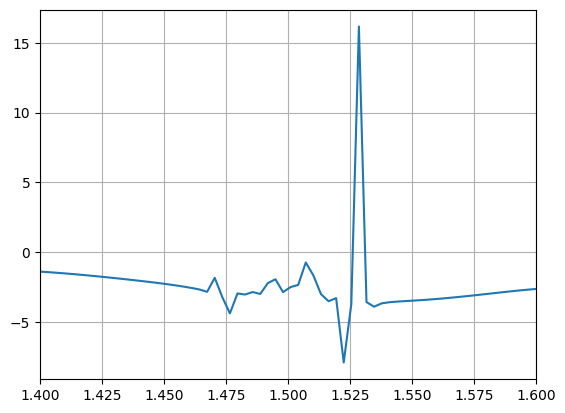

In [707]:
plt.plot(r_c, np.average(lovelace, axis=0))
plt.xlim(1.4,1.6)
plt.grid()

In [ ]:
np

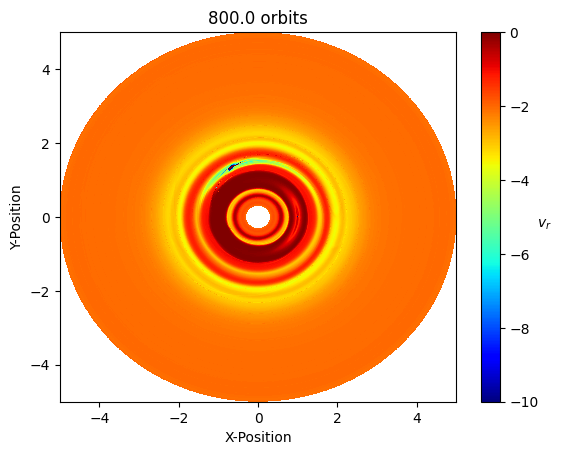

In [888]:
R, PHI = np.meshgrid(r_f, phi_f)
R_C, PHI_C = np.meshgrid(r_c, phi_c)
plt.pcolormesh(R*np.cos(PHI), R*np.sin(PHI), lovelace, cmap='jet', vmin=-10, vmax = 0)
plt.xlabel('X-Position')
plt.ylabel('Y-Position')


plt.title(f'{np.round(orbits,1)} orbits')
plt.colorbar().set_label(r'$v_r$', rotation=0)

$$\mathcal{L}_T = \frac{\Sigma_T S^2}{2 \omega_T}$$

In [ ]:
entropy = press / (dens**(1.001))
lovelace = ((dens + dens_dust)* entropy**2) / (2 * vortensity*(dens + dens_dust))

In [ ]:
plt.plot(r_c, np.average(lovelace, axis=0))

In [ ]:
np.shape(lovelace)

In [ ]:
orbits = np.array([])
index = 0

for i in range(100, 140, 5):
    data = athena_read.athdf(f'/Users/skhan/dust_sim2/disk.out1.00{i}.athdf')
    dens = data.get('dust_1_rho')[0]
    orbits = np.append(orbits, np.round(data.get('Time') / (2 * np.pi), 2))
    dens_average = np.average(dens, axis=0)
    plt.plot(r_c, (dens_average), label=f'{int(orbits[index])} Orbits')
    index += 1

plt.xlabel('R')
plt.ylabel(r'$\Sigma_d$')

#plt.axhline(y=0, linestyle = 'dashed', color = 'black')

plt.tight_layout()
plt.legend()

In [ ]:
sum_dens_onesim = 0
for i in range(170,200,10):
    data = athena_read.athdf(f'/Users/skhan/dust_sim/disk.out1.00{i}.athdf')
    density = data.get('rho')[0]
    #d = initial(data.get('x1v'), data.get('x2v')[:,None], data.get('Time'), 1.0, 0.000954588, 0.000954588)[2]
    #density[d < 0.45 * initial(data.get('x1v'), data.get('x2v')[:,None], data.get('Time'), 1.0, 0.000954588,0.000954588)[3]] = 0
    sum_dens_onesim += density

sum_dens_avg_onesim = sum_dens_onesim/len(range(170,200,10))

In [ ]:
dens_average = np.average(sum_dens_avg_onesim, axis=0)
plt.plot(r_c, (dens_average - r_c**(-1.5))/ (r_c**(-1.5)))
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel('log (R)')
plt.ylabel(r'$\langle \delta \Sigma / \Sigma_0 \rangle$')

plt.xscale('log')

$$(\vec{\nabla} \times \vec{v})_z = \frac{1}{r} (\frac{\partial (r \vec{v_\varphi})}{\partial r} - \frac{\partial \vec{v_r}}{\partial \varphi}) \, \hat{k}$$

$$(\vec{\nabla} \times \vec{v}_K)_z = \frac{1}{\Sigma_0} \frac{1}{r} \frac{d}{dr} (r v_K)$$

In [ ]:
r2d = r_c[np.newaxis, :]
drv_phi_dr = np.gradient(r2d * (np.sqrt(1.0/r_c)), r_c, axis=1)
curl_z = 1/(r_c**(-1.5)) * 1/r_c * drv_phi_dr
vortensity_0 = curl_z/(r_c**(-1.5))

In [ ]:
vortensity_average = -1*np.average(vortensity, axis=0)
plt.plot(r_c, (vortensity_average - vortensity_0[0]))
plt.xlabel('log (R)')
plt.ylabel(r'$\langle \delta \Sigma / \Sigma_0 \rangle$')

In [ ]:
import glob
import matplotlib.animation as animation

# 🔍 Step 1: List and sort your Athena++ output files
file_list = sorted(glob.glob('/Users/skhan/dust_sim/disk.out1.*.athdf'))

# Step 2: Read grid once
data0 = athena_read.athdf(file_list[0])
r_f = data0['x1f']        # radial cell centers
phi_f = data0['x2f']      # azimuthal cell centers
R, PHI = np.meshgrid(r_f, phi_f)  # 2D meshgrid
X = R * np.cos(PHI)
Y = R * np.sin(PHI)

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
mesh = None

def update(frame_idx):
    global mesh, vmin, vmax

    file = file_list[frame_idx]
    data = athena_read.athdf(file)
    vortensity = data.get('user_out_var0')[0]  # [0] = first component (assumes 2D disk)

    ax.clear()
    mesh = ax.pcolormesh(X, Y, vortensity, cmap='jet', vmin = 0.0, vmax = 0.03)
    ax.set_xlabel('X-Position')
    ax.set_ylabel('Y-Position')
    ax.set_title(f'Orbits = {(data["Time"] / (2.*np.pi)):.2f}')
    ax.axis('square')
    return mesh,


# Step 4: Create animation
ani = animation.FuncAnimation(fig, update, frames=len(file_list), blit=False)

# Step 5: Save movie (or show interactively)
ani.save("athena_disk_movie2.gif", writer='pillow', fps=5)
# plt.show()